# Plot ECCO and Satellite SSS for Mackenzie River Mouth

Box bounds used in adjoint:
-143,-130,69,72

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
import re
import glob
import sys
from os.path import join,expanduser

# identify user's home directory
user_home_dir = expanduser('~/github_others')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

## ECCO V4r6

In [59]:
# Open ECCO grid
ecco_grid = xr.open_dataset('~/data/grids/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')

In [61]:
# --- Directory containing ECCO .data files
data_dir = Path("/Users/mzahn/data/ECCO/ECCO_V4r6/SALT_mon_mean")

# --- List and sort all .data files
files = sorted(data_dir.glob("*.data"))
print(f"Found {len(files)} .data files")

Found 396 .data files


In [63]:
# create monthly time coordinate (15th of each month from Jan 1992 to Dec 2024)
time_coord = pd.date_range("1992-01-01", "2024-12-01", freq="MS") + pd.Timedelta(days=14)

# sanity check
if len(files) != len(time_coord):
    print(f"Warning: {len(files)} files but {len(time_coord)} time steps!")

In [65]:
# load all files into xarray DataArrays
arrays = []
for i, filepath in enumerate(files):

    array = ecco.read_llc_to_tiles(
        str(filepath.parent),
        filepath.name, llc=90, nk=50,
        less_output=True
    )

    ds = ecco.llc_tiles_to_xda(
        array,
        var_type="c",
        dim4="depth",
        dim5="time"
    )
    ds = ds.expand_dims("time")
    
    # Assign a single mid-month time coordinate
    ds = ds.assign_coords(time=[time_coord[i]])

    arrays.append(ds)

# --- Combine all DataArrays into one along the time dimension
combined = xr.concat(arrays, dim="time")

# print(combined)

In [66]:
salt_ds = combined.where(ecco_grid.maskC)

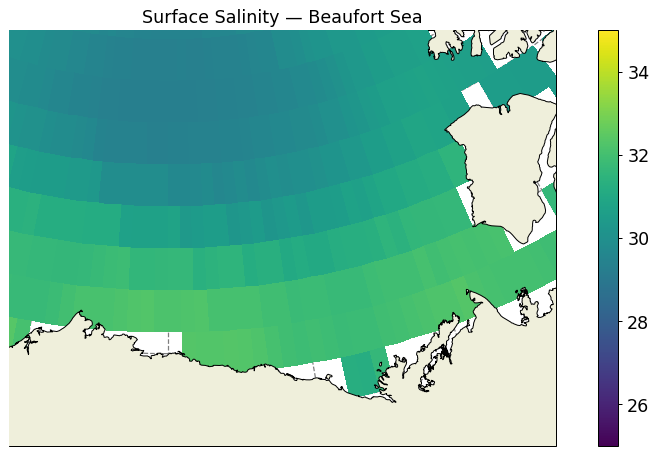

In [67]:
plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = salt_ds.isel(time=0,k=0)

# Create the plot with ECCO’s helper function
f, ax, p, cbar, lon_c, lat_c, data_latlon, gl = ecco.plot_proj_to_latlon_grid(
    ecco_grid.XC, ecco_grid.YC,
    tmp_plt,
    projection_type='stereo',
    plot_type='pcolormesh',
    show_colorbar=True,
    dx=1, dy=1,
    cmin=25, cmax=35,
    lat_lim=60,
    user_lon_0=-150
)

# zoom into the Beaufort Sea (approx bounds)
ax.set_extent([-160, -125, 68, 77], crs=ccrs.PlateCarree())

plt.title("Surface Salinity — Beaufort Sea", fontsize=14)
plt.show();

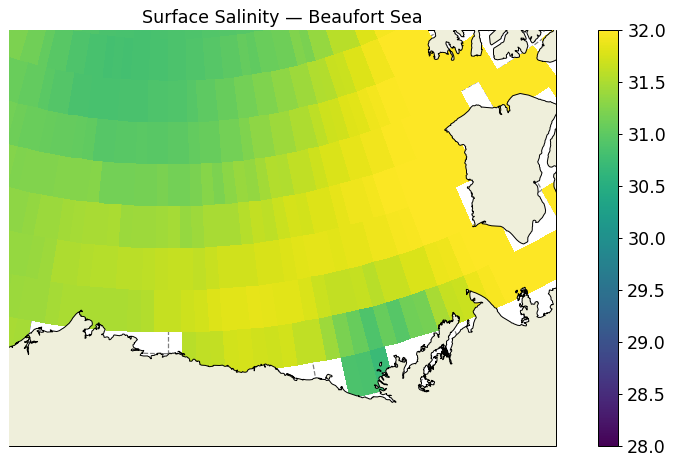

In [68]:
plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = salt_ds.isel(k=0).sel(time='2000-06-15')

# Create the plot with ECCO’s helper function
f, ax, p, cbar, lon_c, lat_c, data_latlon, gl = ecco.plot_proj_to_latlon_grid(
    ecco_grid.XC, ecco_grid.YC,
    tmp_plt,
    projection_type='stereo',
    plot_type='pcolormesh',
    show_colorbar=True,
    dx=1, dy=1,
    cmin=28, cmax=32,
    lat_lim=60,
    user_lon_0=-150
)

# zoom into the Beaufort Sea (approx bounds)
ax.set_extent([-160, -125, 68, 77], crs=ccrs.PlateCarree())

plt.title("Surface Salinity — Beaufort Sea", fontsize=14)
plt.show();

### Remove seasonal cycle

In [71]:
# Months to plot (Sept–Nov)
months_to_plot = [9, 10, 11]

# Latitude/longitude box for Beaufort Sea
lon_bounds = [-160, -125]
lat_bounds = [68, 77]

# Plot limits for color scaling
cmin, cmax = 28, 32

surface_salt = salt_ds.isel(k=0)

# Compute monthly climatology (average over all years for each month)
climatology = surface_salt.groupby("time.month").mean("time")

# Subtract the climatology to remove the seasonal cycle
salt_anom = surface_salt.groupby("time.month") - climatology

/tmp/ipykernel_75354/2635407501.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98])


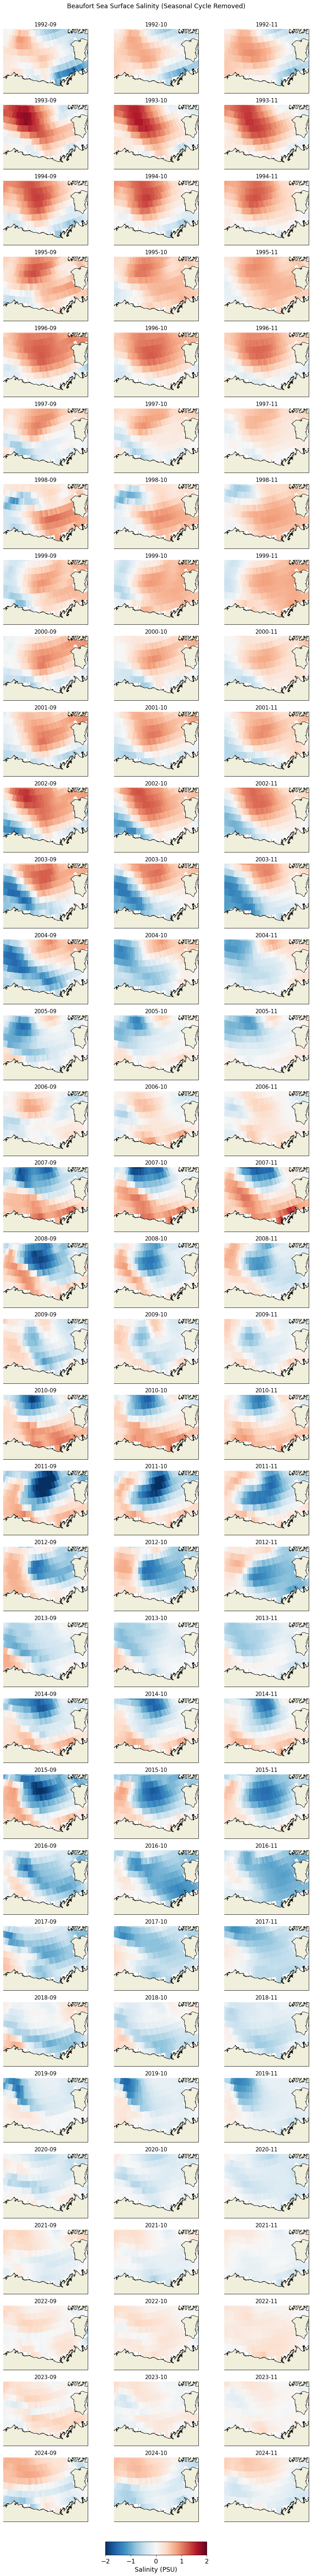

In [72]:
years = np.arange(1992, 2025)
months = [9, 10, 11]

# Set up a figure
fig = plt.figure(figsize=(3.5 * len(months), 2.5 * len(years)), dpi=90)

cmin, cmax = -2, 2
lon_bounds = [-160, -125]
lat_bounds = [68, 77]

for idx, (iyear, imonth) in enumerate([(y, m) for y in years for m in months]):
    sel_time = f"{iyear}-{imonth:02d}-15"
    if sel_time not in salt_anom.time.dt.strftime("%Y-%m-%d"):
        continue

    tmp = salt_anom.sel(time=sel_time)

    # compute the subplot position
    nrows = len(years)
    ncols = len(months)
    # index in subplot_grid is 1-based counting across rows:
    plot_index = idx + 1

    f, ax, p, cbar, lon_c, lat_c, data_latlon, gl = ecco.plot_proj_to_latlon_grid(
        ecco_grid.XC, ecco_grid.YC,
        tmp,
        projection_type='stereo',
        plot_type='pcolormesh',
        show_colorbar=False,
        dx=1, dy=1,
        cmin=cmin, cmax=cmax,
        lat_lim=60,
        user_lon_0=-150,
        cmap='RdBu_r',
        subplot_grid=[nrows, ncols, plot_index]  # use this argument
    )

    ax.set_extent(lon_bounds + lat_bounds, crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.3)
    ax.set_title(f"{iyear}-{imonth:02d}", fontsize=12)

# After loops, add a shared colorbar
fig.subplots_adjust(bottom=0.05, top=0.95)
# [left, bottom, width, height]
cbar_ax = fig.add_axes([0.35, 0.02, 0.3, 0.005])
fig.colorbar(p, cax=cbar_ax, orientation='horizontal', label='Salinity (PSU)')

plt.suptitle("Beaufort Sea Surface Salinity (Seasonal Cycle Removed)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

### Take mean of Beaufort sea region

In [75]:
# define bounds
lon_bounds = [-160, -125]
lat_bounds = [68, 77]

# create mask based on lat/lon bounds
region_mask = (
    (salt_anom.XC >= lon_bounds[0]) & (salt_anom.XC <= lon_bounds[1]) &
    (salt_anom.YC >= lat_bounds[0]) & (salt_anom.YC <= lat_bounds[1])
)

In [76]:
# mask grid cell area for beaufort region
masked_area = ecco_grid.rA.where(region_mask)

# mask salt anom
masked_salt = salt_anom.where(region_mask)

In [77]:
# unweigted mean
sss_avg_unweighted = masked_salt.mean(dim=['j','i','tile'])

In [78]:
# multiply salt anomaly by area to get weighted sum
weighted_salt = masked_salt * masked_area

# sum weighted salt over space (i, j) and divide by total area to get mean
sss_avg = weighted_salt.sum(dim=['j', 'i', 'tile']) / masked_area.sum(dim=['j', 'i', 'tile'])

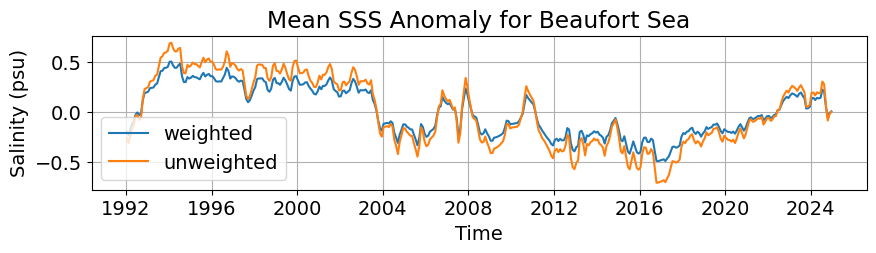

In [79]:
# plotting
sss_avg.plot(figsize=[10,2],label='weighted')
sss_avg_unweighted.plot(label='unweighted')
plt.title("Mean SSS Anomaly for Beaufort Sea")
plt.ylabel("Salinity (psu)")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.show()

### Take mean of Beaufort sea region (sea ice mask)

#### Open sea ice data

In [80]:
# --- Directory containing ECCO .data files
data_dir = Path("/Users/mzahn/data/ECCO/ECCO_V4r6/SIarea_mon_mean")

# --- List and sort all .data files
files = sorted(data_dir.glob("*.data"))
print(f"Found {len(files)} .data files")

Found 396 .data files


In [81]:
# create monthly time coordinate (15th of each month from Jan 1992 to Dec 2024)
time_coord = pd.date_range("1992-01-01", "2024-12-01", freq="MS") + pd.Timedelta(days=14)

# sanity check
if len(files) != len(time_coord):
    print(f"Warning: {len(files)} files but {len(time_coord)} time steps!")

In [82]:
# load all files into xarray DataArrays
arrays = []
for i, filepath in enumerate(files):

    array = ecco.read_llc_to_tiles(
        str(filepath.parent),
        filepath.name, llc=90, nk=1,
        less_output=True
    )

    ds = ecco.llc_tiles_to_xda(
        array,
        var_type="c",
        dim4="depth",
        dim5="time"
    )
    ds = ds.expand_dims("time")
    
    # Assign a single mid-month time coordinate
    ds = ds.assign_coords(time=[time_coord[i]])

    arrays.append(ds)

# --- Combine all DataArrays into one along the time dimension
combined = xr.concat(arrays, dim="time")

In [83]:
sic_ds = combined.where(ecco_grid.maskC.isel(k=0))

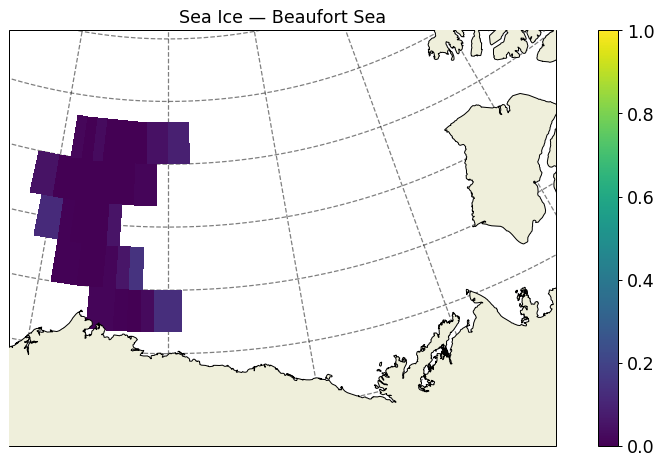

In [84]:
plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = sic_ds.where(sic_ds<0.15).isel(time=250)

# Create the plot with ECCO’s helper function
f, ax, p, cbar, lon_c, lat_c, data_latlon, gl = ecco.plot_proj_to_latlon_grid(
    ecco_grid.XC, ecco_grid.YC,
    tmp_plt,
    projection_type='stereo',
    plot_type='pcolormesh',
    show_colorbar=True,
    dx=1, dy=1,
    cmin=0, cmax=1,
    lat_lim=60,
    user_lon_0=-150
)

# zoom into the Beaufort Sea (approx bounds)
ax.set_extent([-160, -125, 68, 77], crs=ccrs.PlateCarree())

plt.title("Sea Ice — Beaufort Sea", fontsize=14)
plt.show();

In [85]:
# mask salt anom for region and sic
masked_salt_icefree = salt_anom.where(sic_ds<0.15).where(region_mask)

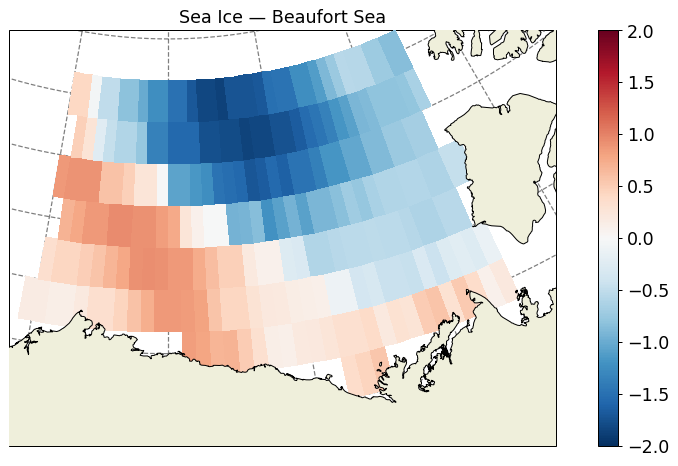

In [86]:
plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = masked_salt.isel(time=200)

# Create the plot with ECCO’s helper function
f, ax, p, cbar, lon_c, lat_c, data_latlon, gl = ecco.plot_proj_to_latlon_grid(
    ecco_grid.XC, ecco_grid.YC,
    tmp_plt,
    projection_type='stereo',
    plot_type='pcolormesh',
    show_colorbar=True,
    dx=1, dy=1,
    cmin=-2, cmax=2,
    lat_lim=60,
    user_lon_0=-150
)

# zoom into the Beaufort Sea (approx bounds)
ax.set_extent([-160, -125, 68, 77], crs=ccrs.PlateCarree())

plt.title("Sea Ice — Beaufort Sea", fontsize=14)
plt.show();

In [89]:
# unweighted mean
sss_avg_icefree_unweighted = masked_salt_icefree.mean(dim=['j','i','tile'])

In [91]:
# mask area where salt anomaly is NaN
valid_area = masked_area.where(~masked_salt_icefree.isnull())

# weighted sum and normalization
weighted_salt_icefree = masked_salt_icefree * masked_area
num = weighted_salt_icefree.sum(dim=['j', 'i', 'tile'], skipna=True)
den = valid_area.sum(dim=['j', 'i', 'tile'], skipna=True)

# avoid divide-by-zero by masking
sss_avg_icefree = num / den
sss_avg_icefree = sss_avg_icefree.where(den > 0)

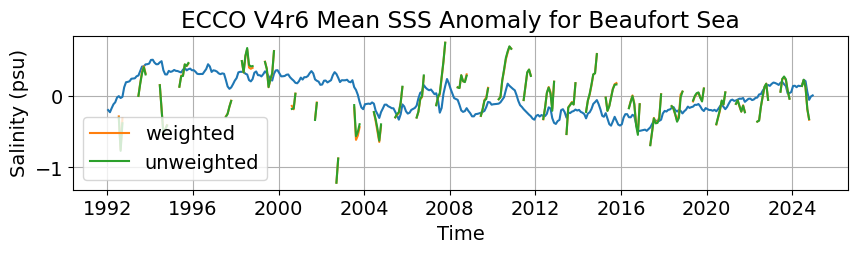

In [92]:
# plotting
sss_avg.plot(figsize=[10,2])
sss_avg_icefree.plot(label='weighted')
sss_avg_icefree_unweighted.plot(label='unweighted')
plt.title("ECCO V4r6 Mean SSS Anomaly for Beaufort Sea")
plt.ylabel("Salinity (psu)")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.show()

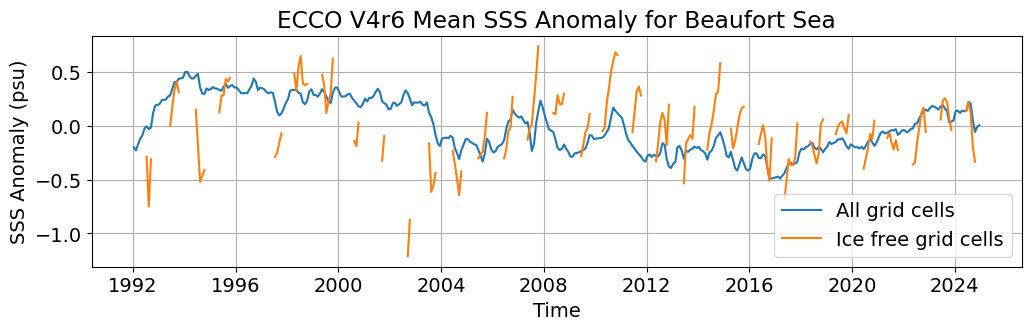

In [93]:
# plotting
plt.rcParams['font.size'] = 14
sss_avg.plot(figsize=[12,3],label='All grid cells')
sss_avg_icefree.plot(label='Ice free grid cells')
plt.title("ECCO V4r6 Mean SSS Anomaly for Beaufort Sea")
plt.ylabel("SSS Anomaly (psu)")
plt.xlabel("Time")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## LOCEAN SMOS Arctic

In [597]:
ds = xr.open_dataset('/Users/mzahn/data/satellite_sss/arctic_locean_smos/SMOS_L3_DEBIAS_LOCEAN_AD_20220904_EASE_Arctic_09d_v02.nc')

In [531]:
# Extract lat/lon
lat = ds["lat"]
lon = ds["lon"]

In [486]:
# Make a mask for the beaufort sea region
mask = (
    (lon >= -170) & (lon <= -120) &
    (lat >= 69) & (lat <= 80)
)

# Apply mask to your variable of interest (replace "sss" with correct variable)
da_region = ds["SSS"].where(mask)

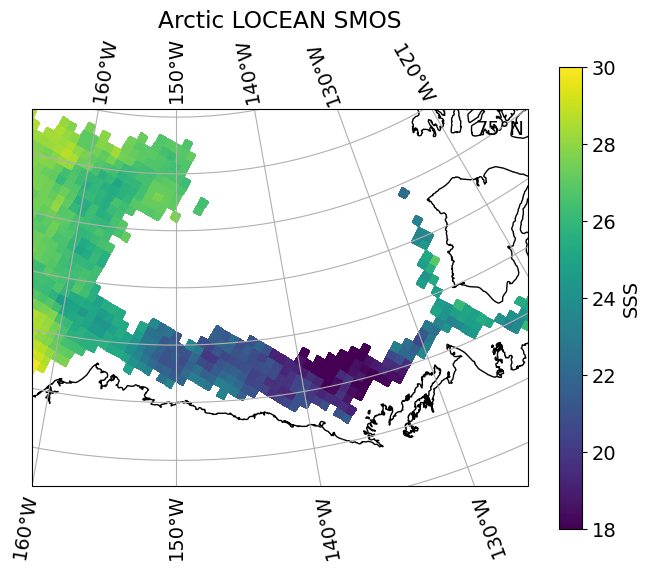

In [488]:
# Choose projection (e.g. North Polar Stereographic)
proj = ccrs.NorthPolarStereo(central_longitude=-150)

fig, ax = plt.subplots(subplot_kw={'projection': proj}, figsize=(8,6))

# Add coastlines and features
ax.coastlines()
ax.gridlines(draw_labels=True)

# Plot region with correct 2D lat/lon
pcm = ax.pcolormesh(
    lon, lat, da_region.isel(time=0),
    transform=ccrs.PlateCarree(),
    cmap="viridis", vmin=18, vmax=30
)

# Set extent around the region of interest
ax.set_extent([-160, -125, 68, 77], crs=ccrs.PlateCarree())

# Colorbar
plt.colorbar(pcm, ax=ax, orientation="vertical", label="SSS")

plt.title("Arctic LOCEAN SMOS")
plt.show()

### Remove seasonal cycle

In [3]:
smos_ds = xr.open_mfdataset('/Users/mzahn/data/satellite_sss/arctic_locean_smos/*.nc',combine='by_coords',chunks={'time': 50},parallel=True)

In [4]:
# Resample to get monthly means (mean for each calendar month in the time series)
monthly_means = smos_ds['SSS'].resample(time='ME').mean()

# Calculate monthly climatology
monthly_climatology = monthly_means.groupby('time.month').mean(dim='time')

# Remove seasonal cycle by subtracting the monthly climatology from monthly means
deseasonalized = monthly_means.groupby('time.month') - monthly_climatology

# Create a new dataset
deseasonalized_ds = xr.Dataset({'sss_anomaly': deseasonalized})

# Add back lat/lon coords
deseasonalized_ds = deseasonalized_ds.assign_coords({'lat': smos_ds['lat'],'lon': smos_ds['lon']})

In [5]:
# Make time coord in middle of the month
# create monthly time coordinate (15th of each month
time_coord = pd.date_range("2010-07-01", "2023-08-01", freq="MS") + pd.Timedelta(days=14)
deseasonalized_ds['time'] = time_coord

In [11]:
# Save to netcdf
deseasonalized_ds.to_netcdf('/Users/mzahn/data/satellite_sss/arctic_locean_smos_sss_monthly_seasonal_cycle_removed.nc')

### Plot

In [13]:
smos_anom_ds = xr.open_dataset('/Users/mzahn/data/satellite_sss/arctic_locean_smos_sss_monthly_seasonal_cycle_removed.nc')

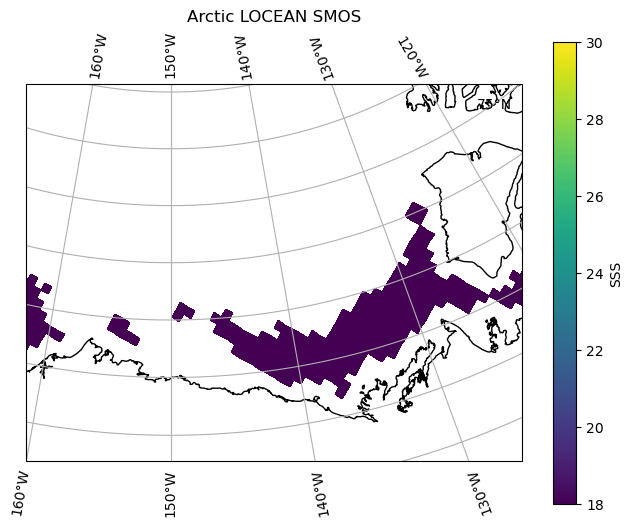

In [19]:
# Choose projection (e.g. North Polar Stereographic)
proj = ccrs.NorthPolarStereo(central_longitude=-150)

fig, ax = plt.subplots(subplot_kw={'projection': proj}, figsize=(8,6))

# Add coastlines and features
ax.coastlines()
ax.gridlines(draw_labels=True)

# Plot region with correct 2D lat/lon
pcm = ax.pcolormesh(
    smos_anom_ds.lon.isel(time=0), smos_anom_ds.lat.isel(time=0), smos_anom_ds.sss_anomaly.isel(time=0),
    transform=ccrs.PlateCarree(),
    cmap="viridis", vmin=18, vmax=30
)

# Set extent around the region of interest
ax.set_extent([-160, -125, 68, 77], crs=ccrs.PlateCarree())

# Colorbar
plt.colorbar(pcm, ax=ax, orientation="vertical", label="SSS")

plt.title("Arctic LOCEAN SMOS")
plt.show()

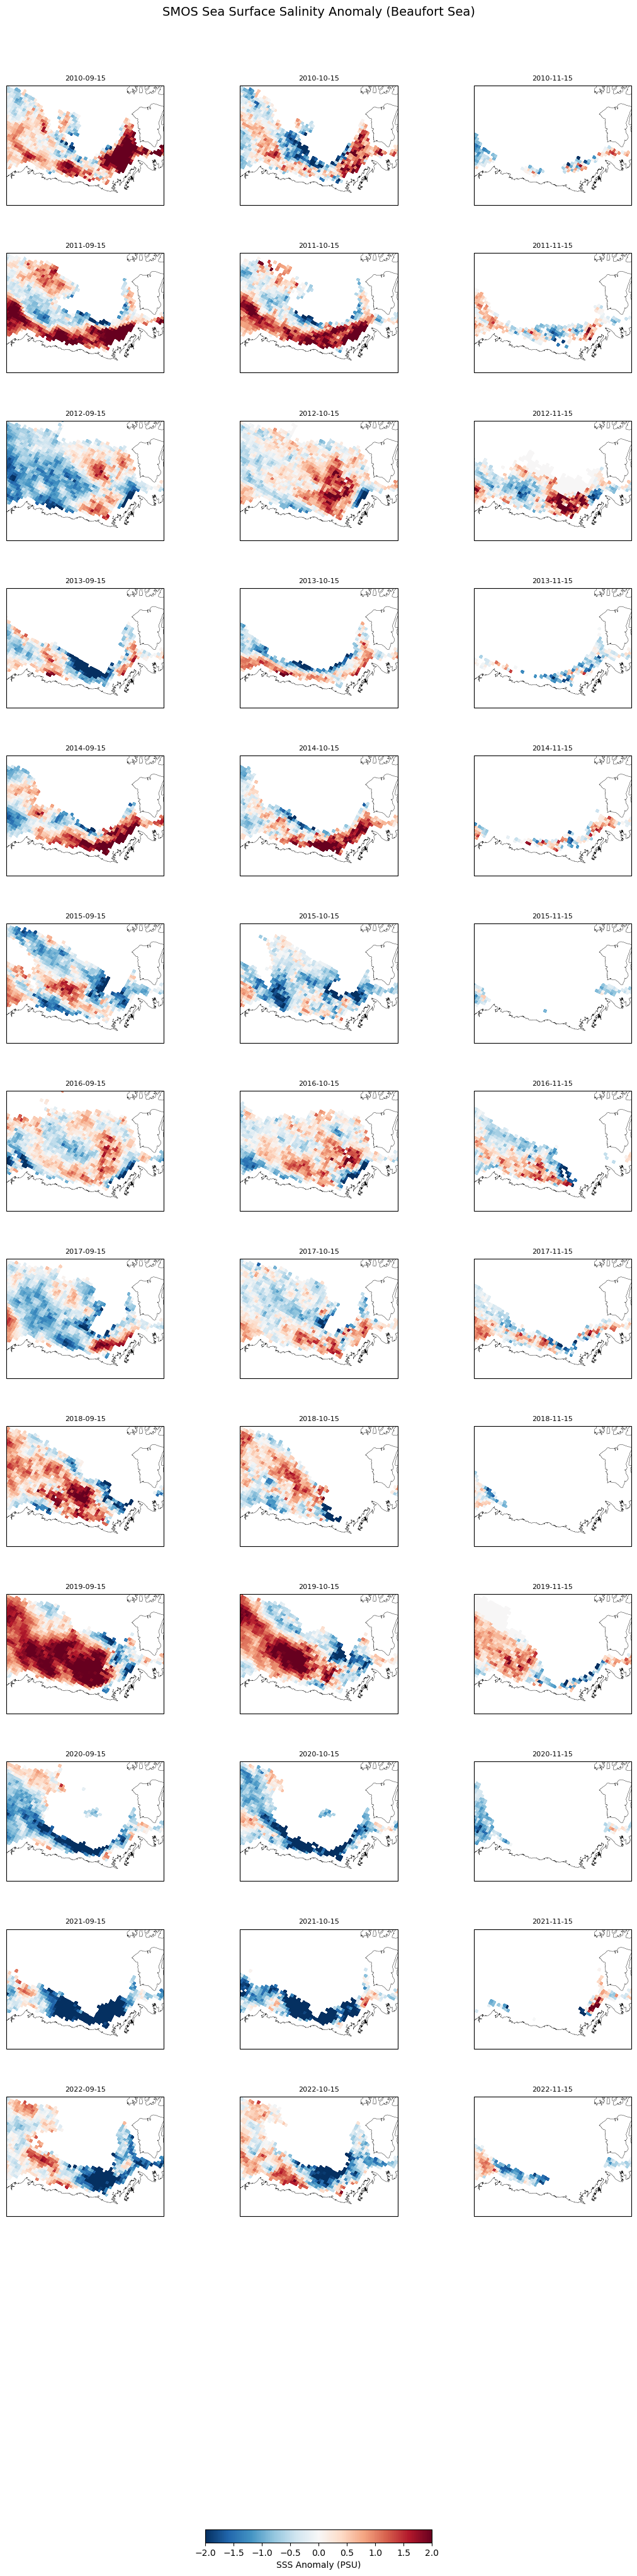

In [30]:
years = np.arange(2010, 2024)
months = [9, 10, 11]

# Set up figure size based on number of subplots
fig = plt.figure(figsize=(4 * len(months), 3 * len(years)))

# Color scale limits for anomaly
vmin, vmax = -2, 2

# Plotting extent (Beaufort Sea)
lon_bounds = [-160, -125]
lat_bounds = [68, 77]

# Create list of (year, month) pairs
time_pairs = [(y, m) for y in years for m in months]

# Subplot grid dimensions
nrows = len(years)
ncols = len(months)

# Loop through year-month combinations
plot_idx = 1
for iyear, imonth in time_pairs:
    sel_time_str = f"{iyear}-{imonth:02d}-15"
    
    # Skip if time is not in dataset
    if sel_time_str not in smos_anom_ds.time.dt.strftime("%Y-%m-%d").values:
        continue

    # Select the time index
    sel_data = smos_anom_ds.sel(time=sel_time_str)
    
    # Create subplot with polar projection
    ax = fig.add_subplot(nrows, ncols, plot_idx, projection=ccrs.NorthPolarStereo(central_longitude=-150))
    
    # Plot the anomaly
    pcm = ax.pcolormesh(
        sel_data.lon, sel_data.lat, sel_data.sss_anomaly,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r", vmin=vmin, vmax=vmax
    )
    
    # Add map features
    ax.set_extent(lon_bounds + lat_bounds, crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.3)
    ax.set_title(sel_time_str, fontsize=8)
    
    plot_idx += 1

# Adjust spacing
fig.subplots_adjust(bottom=0.08, top=0.95, left=0.05, right=0.95, hspace=0.4, wspace=0.1)

# Shared colorbar
cbar_ax = fig.add_axes([0.35, 0.03, 0.3, 0.01])  # [left, bottom, width, height]
fig.colorbar(pcm, cax=cbar_ax, orientation="horizontal", label="SSS Anomaly (PSU)")

# Main title
plt.suptitle("SMOS Sea Surface Salinity Anomaly (Beaufort Sea)", fontsize=14)

plt.show()

### Calculate the mean

In [36]:
# define bounds
lon_bounds = [-160, -125]
lat_bounds = [68, 77]

# create mask based on lat/lon bounds
region_mask = (
    (smos_anom_ds.lon >= lon_bounds[0]) & (smos_anom_ds.lon <= lon_bounds[1]) &
    (smos_anom_ds.lat >= lat_bounds[0]) & (smos_anom_ds.lat <= lat_bounds[1])
)

In [38]:
smos_anom_beaufort = smos_anom_ds.where(region_mask)

In [46]:
smos_anom_avg = smos_anom_beaufort.mean(dim=['nx','ny'])

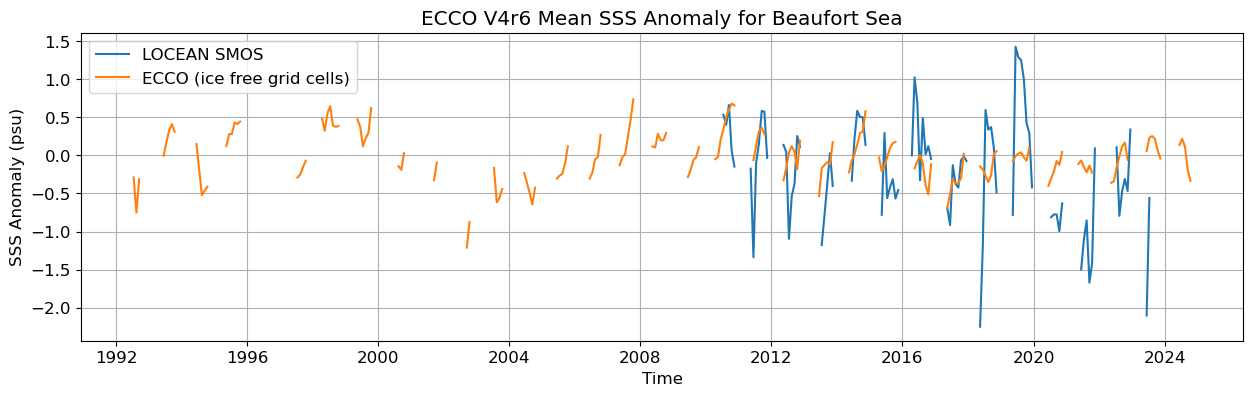

In [117]:
# plotting
plt.rcParams['font.size'] = 12
smos_anom_avg.sss_anomaly.plot(figsize=[15,4],label='LOCEAN SMOS')
sss_avg_icefree.plot(label='ECCO (ice free grid cells)')
plt.title("ECCO V4r6 Mean SSS Anomaly for Beaufort Sea")
plt.ylabel("SSS Anomaly (psu)")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.show()

## CCI SSS

In [ ]:
ds = xr.open_dataset('/Users/mzahn/data/satellite_sss/cci_sss/ESACCI-SEASURFACESALINITY-L4-SSS-POLAR-MERGED_OI_7DAY_RUNNINGMEAN_DAILY_25kmEASE2_NH-20100915-fv5.5.nc')

In [ ]:
ds

## SMAP v6

In [ ]:
ds = xr.open_dataset('/Users/mzahn/data/satellite_sss/smap_v6/RSS_smap_SSS_L3_8day_running_2017_259_FNL_v06.0.nc')

In [ ]:
ds.sss_smap.plot();

In [ ]:
tmp = ds.sss_smap.sel(lat=slice(69,72),lon=slice(360-143,360-130))

In [ ]:
ds

In [ ]:
tmp.plot()

In [ ]:
ds

In [ ]:
# Input and output directories
input_dir = Path("/Users/mzahn/data/satellite_sss/smap_v6")
output_dir = Path("/Users/mzahn/data/satellite_sss/MACK_CUTOUT/smap_v6")
output_dir.mkdir(parents=True, exist_ok=True)

# Loop over all netCDF files
for file in input_dir.glob("*.nc"):
    # print(f"Processing {file.name}")
    
    # Open dataset
    ds = xr.open_dataset(file)
    
    # Extract SSS variable
    sss = ds['sss_smap']
    
    # Select cutout (lon converted to 0-360)
    cutout = sss.sel(lat=slice(69, 72), lon=slice(360-143, 360-130))
    
    # Re-add time coordinate
    cutout = cutout.expand_dims('time')
    cutout['time'] = ds['time']
    
    # Convert filename DOY to date
    # Example: RSS_smap_SSS_L3_8day_running_2017_008_FNL_v06.0.nc
    match = re.search(r"(\d{4})_(\d{3})", file.name)
    if match:
        year = int(match.group(1))
        doy = int(match.group(2))
        date = pd.to_datetime(f"{year}-01-01") + pd.to_timedelta(doy - 1, unit='D')
        date_str = date.strftime("%Y%m%d")
        new_filename = re.sub(r"\d{4}_\d{3}", f"{year}{date_str[4:]}", file.name)
    else:
        new_filename = file.name  # fallback
    
    # Save cutout
    cutout.to_netcdf(output_dir / new_filename)
    # print(f"Saved cutout to {output_dir / new_filename}")

In [ ]:
ds = xr.open_dataset('/Users/mzahn/data/satellite_sss/MACK_CUTOUT/smap_v6/RSS_smap_SSS_L3_8day_running_20150911_FNL_v06.0.nc')

In [ ]:
ds.sss_smap.plot();